In [1]:
# Import of libraries

# System libraries
import re
import os
import unicodedata
import itertools

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Database
import duckdb

# Data visualization
import pysmiles
import plotly
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
# Python version
from IPython.display import SVG
IPythonConsole.ipython_useSVG=True

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

Python version in this Jupyter Notebook: 3.11.5
Author: Library versions

rdkit     : 2024.3.6
plotly    : 5.9.0
watermark : 2.5.0
seaborn   : 0.12.2
pysmiles  : 1.1.2
platform  : 1.0.8
duckdb    : 1.1.3
IPython   : 8.20.0
numpy     : 1.24.3
re        : 2.2.1
pandas    : 1.5.3
matplotlib: 3.7.2



In [2]:
# Database - Parquet format
data_train = 'data/train.parquet'
test_path = 'data/test.parquet'

# Bank connection
con = duckdb.connect()

# Query
data = con.query(f"""(SELECT * FROM parquet_scan('{data_train}') 
WHERE binds = 0
ORDER BY random()
LIMIT 30000)
UNION ALL
(SELECT * FROM parquet_scan('{data_train}')
WHERE binds = 1
ORDER BY random()
LIMIT 30000)""").df()

# Closing database
con.close()

# Saving dataset
data.to_csv("output/dataset30000.csv")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
# Viewing first 5 data
data.head()

id                              buildingblock1_smiles  \
0  202147386      O=C(Nc1ccc(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
1   45860315  Cc1c(Br)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21   
2  269773993  O=C(O)C[C@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-c...   
3  255909799  O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...   
4   44492705  C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...   

    buildingblock2_smiles   buildingblock3_smiles  \
0               Cl.NCCCCF             N#Cc1ccsc1N   
1  CCOC(=O)c1ccc(O)c(N)c1               NCc1ccon1   
2   Cl.NCc1noc2ccc(F)cc12     Cc1nc(CN)oc1C.Cl.Cl   
3          Nc1ccc2ncoc2c1             Cn1ccc(N)n1   
4            Nc1ccc(F)cn1  Cl.Cl.NCCCN1CCNC(=O)C1   

                                     molecule_smiles protein_name  binds  
0  N#Cc1ccsc1Nc1nc(NCCCCF)nc(Nc2ccc(F)cc2C(=O)N[D...         BRD4      0  
1  CCOC(=O)c1ccc(O)c(Nc2nc(NCc3ccon3)nc(Nc3c(C(=O...          sEH      0  
2  Cc1nc(CNc2nc(NCc3noc4ccc(F)cc34)nc(N[C@H](CC(=...          HSA      0  
3  Cn1ccc(Nc2nc(Nc3ccc4ncoc4c3)nc(N[C@H](CC(=O)N[...          HSA      0  
4  C[C@@H](OCc1ccccc1)[C@H](Nc1nc(NCCCN2CCNC(=O)C...          sEH      0

In [4]:
# Viewing 5 latest data
data.tail()

id                              buildingblock1_smiles  \
59995   11770632  CC(=O)c1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc3...   
59996   82512206      O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21   
59997  100678598  O=C(N[C@@H](Cc1ccc(I)cc1)C(=O)O)OCC1c2ccccc2-c...   
59998   14150547  CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21...   
59999   83613935  O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...   

                 buildingblock2_smiles             buildingblock3_smiles  \
59995  Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]     Cl.NCCN1C(=O)c2ccccc2S1(=O)=O   
59996                NCc1cc(=O)c(O)co1  Nc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O   
59997             Cc1sc(C)c(CN)c1Br.Cl                NCCC(=O)NCc1ccncc1   
59998                         Nc1ncco1                   CC(CN)Sc1ccccc1   
59999     NCc1ccccc1CS(=O)(=O)N1CCOCC1              Nc1nc(F)nc2nc[nH]c12   

                                         molecule_smiles protein_name  binds  
59995  CC(=O)c1ccc(C[C@H](Nc2nc(NCCN3C(=O)c4ccccc4S3(...         BRD4      1  
59996  O=C1CCC(N2Cc3c(Nc4nc(NCc5cc(=O)c(O)co5)nc(NCC5...          sEH      1  
59997  Cc1sc(C)c(CNc2nc(NCCC(=O)NCc3ccncc3)nc(N[C@@H]...          sEH      1  
59998  CC(CNc1nc(Nc2ncco2)nc(NC(CCC(=O)OC(C)(C)C)C(=O...         BRD4      1  
59999  O=C(N[Dy])[C@H]1CC[C@H](CNc2nc(NCc3ccccc3CS(=O...          sEH      1

In [5]:
# Rows and columns
data.shape

(60000, 7)

In [6]:
# Info data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     60000 non-null  int64 
 1   buildingblock1_smiles  60000 non-null  object
 2   buildingblock2_smiles  60000 non-null  object
 3   buildingblock3_smiles  60000 non-null  object
 4   molecule_smiles        60000 non-null  object
 5   protein_name           60000 non-null  object
 6   binds                  60000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 3.2+ MB


In [7]:
# Data type
data.dtypes

id                        int64
buildingblock1_smiles    object
buildingblock2_smiles    object
buildingblock3_smiles    object
molecule_smiles          object
protein_name             object
binds                     int64
dtype: object

In [8]:
# Converting column
data['molecule'] = data['molecule_smiles'].apply(Chem.MolFromSmiles)

# Creating a onehotencode function
def modl(molecule_data, radius=2, bits=1024):
    if molecule_data is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule_data, radius, nBits=bits))

# Viewing new column
data['H1_ecfp'] = data['molecule'].apply(modl)

# New column
data.head()

[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerator
[15:09:32] DEPRECATION WARNING: please use MorganGenerat

id                              buildingblock1_smiles  \
0  202147386      O=C(Nc1ccc(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
1   45860315  Cc1c(Br)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21   
2  269773993  O=C(O)C[C@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-c...   
3  255909799  O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...   
4   44492705  C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...   

    buildingblock2_smiles   buildingblock3_smiles  \
0               Cl.NCCCCF             N#Cc1ccsc1N   
1  CCOC(=O)c1ccc(O)c(N)c1               NCc1ccon1   
2   Cl.NCc1noc2ccc(F)cc12     Cc1nc(CN)oc1C.Cl.Cl   
3          Nc1ccc2ncoc2c1             Cn1ccc(N)n1   
4            Nc1ccc(F)cn1  Cl.Cl.NCCCN1CCNC(=O)C1   

                                     molecule_smiles protein_name  binds  \
0  N#Cc1ccsc1Nc1nc(NCCCCF)nc(Nc2ccc(F)cc2C(=O)N[D...         BRD4      0   
1  CCOC(=O)c1ccc(O)c(Nc2nc(NCc3ccon3)nc(Nc3c(C(=O...          sEH      0   
2  Cc1nc(CNc2nc(NCc3noc4ccc(F)cc34)nc(N[C@H](CC(=...          HSA      0   
3  Cn1ccc(Nc2nc(Nc3ccc4ncoc4c3)nc(N[C@H](CC(=O)N[...          HSA      0   
4  C[C@@H](OCc1ccccc1)[C@H](Nc1nc(NCCCN2CCNC(=O)C...          sEH      0   

                                            molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
1  <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
3  <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
4  <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   

                                             H1_ecfp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [9]:
# Importing library
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
encoder_onehot = OneHotEncoder(sparse_output=False)

# Training
encoder_onehot_fit = encoder_onehot.fit_transform(data['protein_name'].values.reshape(-1, 1))

# Viewing
encoder_onehot

OneHotEncoder(sparse_output=False)

In [24]:
data_vis = data
data_vis["onehot"] = list(encoder_onehot_fit)

data_vis

id                              buildingblock1_smiles  \
0      202147386      O=C(Nc1ccc(F)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21   
1       45860315  Cc1c(Br)ccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21   
2      269773993  O=C(O)C[C@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-c...   
3      255909799  O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...   
4       44492705  C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...   
...          ...                                                ...   
59995   11770632  CC(=O)c1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc3...   
59996   82512206      O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21   
59997  100678598  O=C(N[C@@H](Cc1ccc(I)cc1)C(=O)O)OCC1c2ccccc2-c...   
59998   14150547  CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21...   
59999   83613935  O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...   

                 buildingblock2_smiles             buildingblock3_smiles  \
0                            Cl.NCCCCF                       N#Cc1ccsc1N   
1               CCOC(=O)c1ccc(O)c(N)c1                         NCc1ccon1   
2                Cl.NCc1noc2ccc(F)cc12               Cc1nc(CN)oc1C.Cl.Cl   
3                       Nc1ccc2ncoc2c1                       Cn1ccc(N)n1   
4                         Nc1ccc(F)cn1            Cl.Cl.NCCCN1CCNC(=O)C1   
...                                ...                               ...   
59995  Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-]     Cl.NCCN1C(=O)c2ccccc2S1(=O)=O   
59996                NCc1cc(=O)c(O)co1  Nc1cccc2c1CN(C1CCC(=O)NC1=O)C2=O   
59997             Cc1sc(C)c(CN)c1Br.Cl                NCCC(=O)NCc1ccncc1   
59998                         Nc1ncco1                   CC(CN)Sc1ccccc1   
59999     NCc1ccccc1CS(=O)(=O)N1CCOCC1              Nc1nc(F)nc2nc[nH]c12   

                                         molecule_smiles protein_name  binds  \
0      N#Cc1ccsc1Nc1nc(NCCCCF)nc(Nc2ccc(F)cc2C(=O)N[D...         BRD4      0   
1      CCOC(=O)c1ccc(O)c(Nc2nc(NCc3ccon3)nc(Nc3c(C(=O...          sEH      0   
2      Cc1nc(CNc2nc(NCc3noc4ccc(F)cc34)nc(N[C@H](CC(=...          HSA      0   
3      Cn1ccc(Nc2nc(Nc3ccc4ncoc4c3)nc(N[C@H](CC(=O)N[...          HSA      0   
4      C[C@@H](OCc1ccccc1)[C@H](Nc1nc(NCCCN2CCNC(=O)C...          sEH      0   
...                                                  ...          ...    ...   
59995  CC(=O)c1ccc(C[C@H](Nc2nc(NCCN3C(=O)c4ccccc4S3(...         BRD4      1   
59996  O=C1CCC(N2Cc3c(Nc4nc(NCc5cc(=O)c(O)co5)nc(NCC5...          sEH      1   
59997  Cc1sc(C)c(CNc2nc(NCCC(=O)NCc3ccncc3)nc(N[C@@H]...          sEH      1   
59998  CC(CNc1nc(Nc2ncco2)nc(NC(CCC(=O)OC(C)(C)C)C(=O...         BRD4      1   
59999  O=C(N[Dy])[C@H]1CC[C@H](CNc2nc(NCc3ccccc3CS(=O...          sEH      1   

                                                molecule  \
0      <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
1      <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
2      <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
3      <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
4      <rdkit.Chem.rdchem.Mol object at 0x00000202B24...   
...                                                  ...   
59995  <rdkit.Chem.rdchem.Mol object at 0x00000202AF5...   
59996  <rdkit.Chem.rdchem.Mol object at 0x00000202AF5...   
59997  <rdkit.Chem.rdchem.Mol object at 0x00000202AF5...   
59998  <rdkit.Chem.rdchem.Mol object at 0x00000202AF5...   
59999  <rdkit.Chem.rdchem.Mol object at 0x00000202AF5...   

                                                 H1_ecfp           onehot  
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  [1.0, 0.0, 0.0]  
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  [0.0, 0.0, 1.0]  
2      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [0.0, 1.0, 0.0]  
3      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  [0.0, 1.0, 0.0]  
4      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [0.0, 0.0, 1.0]  
...                                                  ...              ...  
59995  [0, 1, 0, 0, 0, 0, 0, 0, 0,

In [160]:
# Viewing column
data.protein_name

0         HSA
1         HSA
2        BRD4
3         sEH
4         sEH
         ... 
59995     sEH
59996    BRD4
59997     sEH
59998     HSA
59999    BRD4
Name: protein_name, Length: 60000, dtype: object

In [161]:
print(type(data)) 

<class 'pandas.core.frame.DataFrame'>


In [162]:
# Combine ECFPs and one-hot encoded protein_name
print(encoder_onehot_fit.shape)
print(data['H1_ecfp'].shape)
# 确保 'H1_ecfp' 是一个长度为 1024 的数组
ecfp_arr = np.array(data['H1_ecfp'].tolist())  # 转换为二维数组，形状是 (1674896, 1024)
print(ecfp_arr.shape)

encoder = np.array(encoder_onehot_fit.tolist())
print(encoder.shape)
X = [ecfp + protein for ecfp, protein in zip(data['H1_ecfp'].tolist(), encoder_onehot_fit.tolist())]
y = data['binds'].tolist()

(60000, 3)
(60000,)
(60000, 1024)
(60000, 3)


In [163]:
# Importing library
from sklearn.model_selection import train_test_split

# Model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
%%time
import joblib
# Importing libraries
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance as plot_importance_xgb
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# Metrics and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report

# 忽略特定类型的警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
# Machine learning model
models = { 
    
    # model Logistic Regression
    "Logistic_Regression": LogisticRegression(),
    
    # model Naive bayes
    "Naive_bayes": GaussianNB(),
    
    # model KNN
    "KNN": KNeighborsClassifier(),
    
    # model AdaBoost
    "Ada_Boost": AdaBoostClassifier(),
    
    # model Gradient Boosting
    "Gradient_Boosting_Classifier": GradientBoostingClassifier(),
    
    # model Decision Tree Classifier - With adjusted internal parameters
    "Decision_Tree_Classifier": DecisionTreeClassifier(max_depth=5, 
                                                       min_samples_split=2, 
                                                       random_state=105),

    # Random Forest Classifier
    "Random_Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
    
    # model XGBoost - With adjusted internal parameters
    "XGBoost": XGBClassifier(n_estimators=100,
                             max_depth=250,
                             learning_rate=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='multi:softmax',
                             num_class=3,
                             random_state=42,
                             tree_method='gpu_hist'),
    
    # model LGBM - with adjusted internal parameters
    "LGBM": LGBMClassifier(boosting_type='gbdt',
                           bagging_freq=5,
                           verbose=0,
                           device='gpu',
                           num_leaves=31,
                           max_depth=250,
                           learning_rate=0.1,
                           n_estimators=100),

    
    # CatBoost
    "CatBoost": CatBoostClassifier(iterations=100,
                                   learning_rate=0.1,
                                   depth=10,
                                   cat_features=None,  # Specify the categorical feature indices if available
                                   task_type='GPU',
                                   devices='0',  # Set to '0' for the first GPU, adjust if needed
                                   early_stopping_rounds=10,
                                   verbose=0),
    
    # Multi-layer Perception classifier
     "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)

}

# Training models
# for name, model in tqdm(models.items(), desc="Training models", total=len(models)):
    
#     # # Model training
#     model.fit(X_train, y_train)

#     # 保存模型
#     joblib.dump(model, f"ckpoint/morgan/{name}_model.pkl")
    
#     # Cross-validation
#     score_training = cross_val_score(model, X_train, y_train, cv=10)
    
#     # Model forecast
#     pred_model = model.predict(X_test)
    
#     # Viewing models
#     tqdm.write("Model: {} has Accuracy {:.2f}%".format(model.__class__.__name__, round(score_training.mean(), 2) * 100))
#     print()



CPU times: total: 0 ns
Wall time: 16.1 ms


In [165]:
# 读取模型
# %%time
import joblib
# Importing libraries
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance as plot_importance_xgb
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# Metrics and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report

# Machine learning model
models = { 
    
    # model Logistic Regression
    "Logistic_Regression": LogisticRegression(),
    
    # model Naive bayes
    "Naive_bayes": GaussianNB(),
    
    # model KNN
    "KNN": KNeighborsClassifier(),
    
    # model AdaBoost
    "Ada_Boost": AdaBoostClassifier(),
    
    # model Gradient Boosting
    "Gradient_Boosting_Classifier": GradientBoostingClassifier(),
    
    # model Decision Tree Classifier - With adjusted internal parameters
    "Decision_Tree_Classifier": DecisionTreeClassifier(max_depth=5, 
                                                       min_samples_split=2, 
                                                       random_state=105),

    # Random Forest Classifier
    "Random_Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
    
    # model XGBoost - With adjusted internal parameters
    "XGBoost": XGBClassifier(n_estimators=100,
                             max_depth=250,
                             learning_rate=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='multi:softmax',
                             num_class=3,
                             random_state=42,
                             tree_method='gpu_hist'),
    
    # model LGBM - with adjusted internal parameters
    "LGBM": LGBMClassifier(boosting_type='gbdt',
                           bagging_freq=5,
                           verbose=0,
                           device='gpu',
                           num_leaves=31,
                           max_depth=250,
                           learning_rate=0.1,
                           n_estimators=100),

    
    # CatBoost
    "CatBoost": CatBoostClassifier(iterations=100,
                                   learning_rate=0.1,
                                   depth=10,
                                   cat_features=None,  # Specify the categorical feature indices if available
                                   task_type='GPU',
                                   devices='0',  # Set to '0' for the first GPU, adjust if needed
                                   early_stopping_rounds=10,
                                   verbose=0),
    
    # Multi-layer Perception classifier
     "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)

}

for name, model in tqdm(models.items(), desc="Loading models", total=len(models)):
    model = joblib.load(f"ckpoint/morgan/{name}_model.pkl")
    # Cross-validation
    # score_training = cross_val_score(model, X_train, y_train, cv=10)
    
    # Model forecast
    pred_model = model.predict(X_test)

    # 计算模型的准确率
    accuracy = accuracy_score(y_test, pred_model)
    
    # 输出模型的准确率
    tqdm.write("Model: {} has Accuracy {:.2f}%".format(model.__class__.__name__, accuracy * 100))
    print()

Loading models:   9%|▉         | 1/11 [00:00<00:04,  2.45it/s]

Model: LogisticRegression has Accuracy 86.91%



Loading models:  18%|█▊        | 2/11 [00:00<00:04,  2.09it/s]

Model: GaussianNB has Accuracy 73.57%



Loading models:  27%|██▋       | 3/11 [00:03<00:12,  1.53s/it]

Model: KNeighborsClassifier has Accuracy 81.14%



Loading models:  36%|███▋      | 4/11 [00:04<00:09,  1.39s/it]

Model: AdaBoostClassifier has Accuracy 78.42%



Loading models:  45%|████▌     | 5/11 [00:05<00:05,  1.00it/s]

Model: GradientBoostingClassifier has Accuracy 83.91%



Loading models:  55%|█████▍    | 6/11 [00:05<00:03,  1.33it/s]

Model: DecisionTreeClassifier has Accuracy 74.31%



Loading models:  64%|██████▎   | 7/11 [00:05<00:02,  1.54it/s]

Model: RandomForestClassifier has Accuracy 80.64%



Loading models:  73%|███████▎  | 8/11 [00:06<00:02,  1.48it/s]

Model: XGBClassifier has Accuracy 91.77%



Loading models:  82%|████████▏ | 9/11 [00:07<00:01,  1.64it/s]

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Model: LGBMClassifier has Accuracy 89.45%



Loading models:  91%|█████████ | 10/11 [00:09<00:01,  1.04s/it]

Model: CatBoostClassifier has Accuracy 89.77%



Loading models: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]

Model: MLPClassifier has Accuracy 90.71%




Machine Learning Model: Logistic_Regression





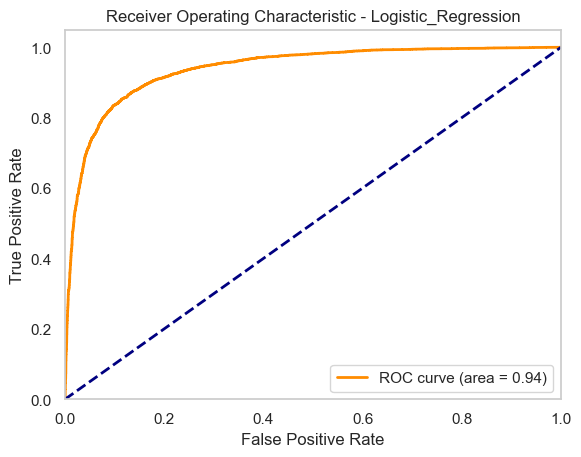



Accuracy: 0.8679166666666667






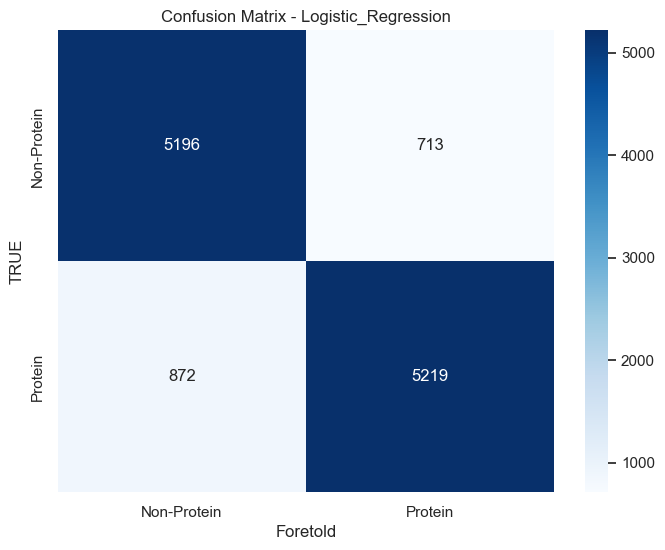



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5909
           1       0.88      0.86      0.87      6091

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000


Machine Learning Model: Naive_bayes





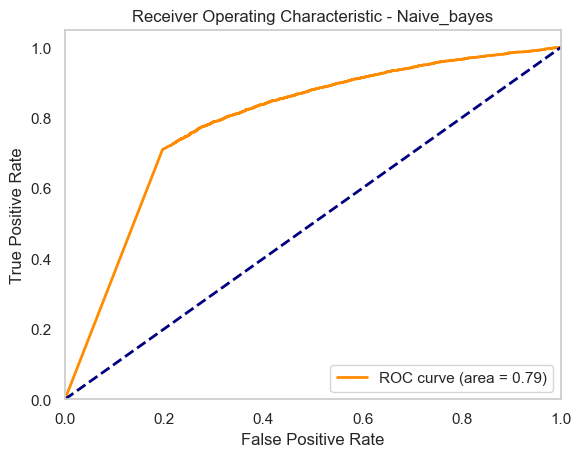



Accuracy: 0.7359166666666667






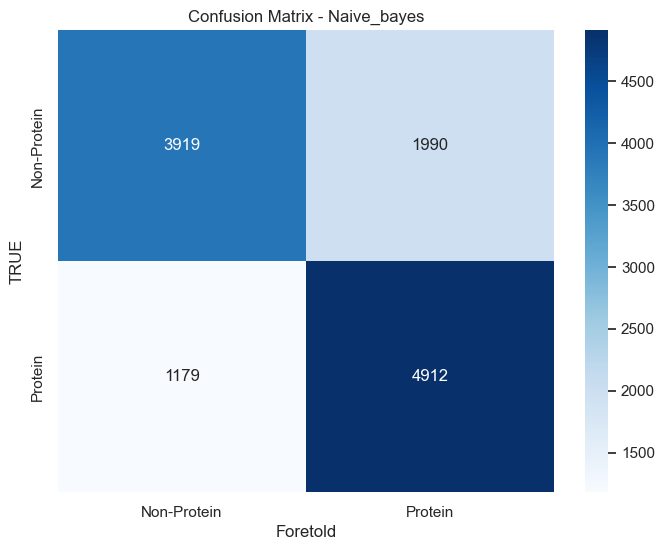



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71      5909
           1       0.71      0.81      0.76      6091

    accuracy                           0.74     12000
   macro avg       0.74      0.73      0.73     12000
weighted avg       0.74      0.74      0.73     12000


Machine Learning Model: KNN





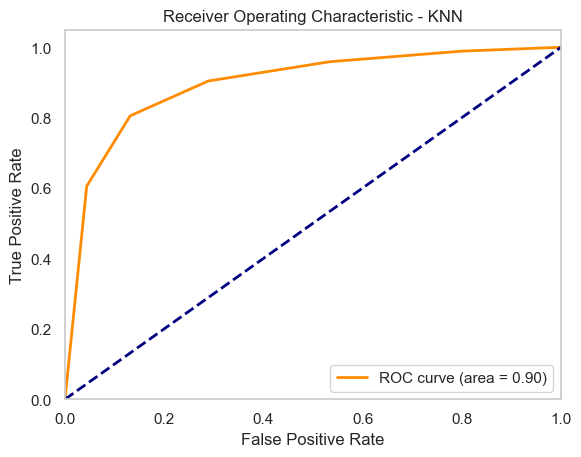



Accuracy: 0.8090833333333334






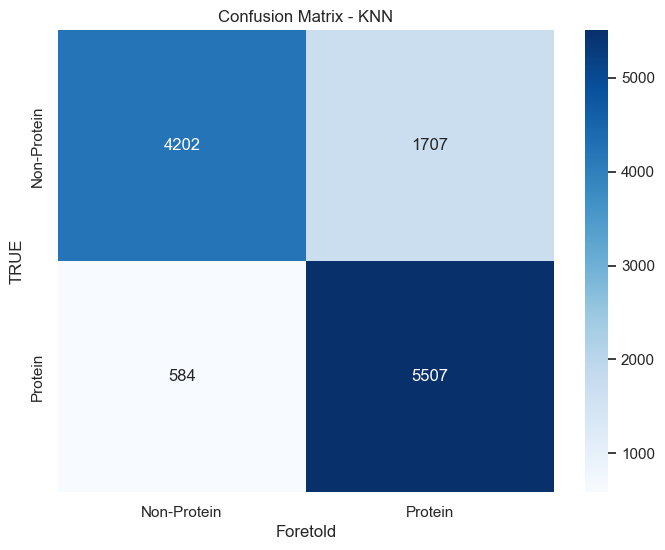



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      5909
           1       0.76      0.90      0.83      6091

    accuracy                           0.81     12000
   macro avg       0.82      0.81      0.81     12000
weighted avg       0.82      0.81      0.81     12000


Machine Learning Model: Ada_Boost





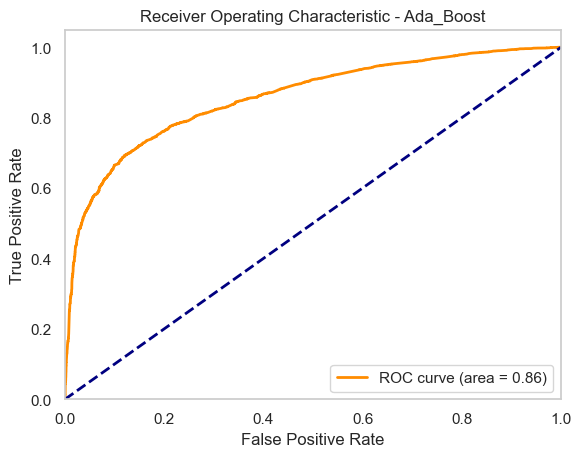



Accuracy: 0.7838333333333334






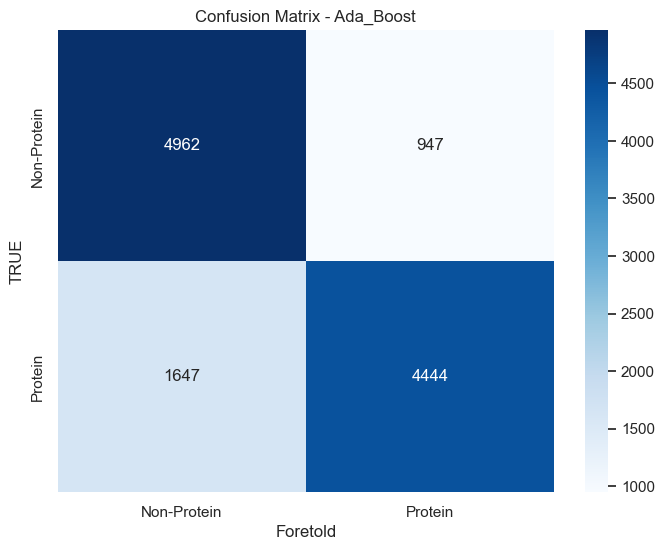



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      5909
           1       0.82      0.73      0.77      6091

    accuracy                           0.78     12000
   macro avg       0.79      0.78      0.78     12000
weighted avg       0.79      0.78      0.78     12000


Machine Learning Model: Gradient_Boosting_Classifier





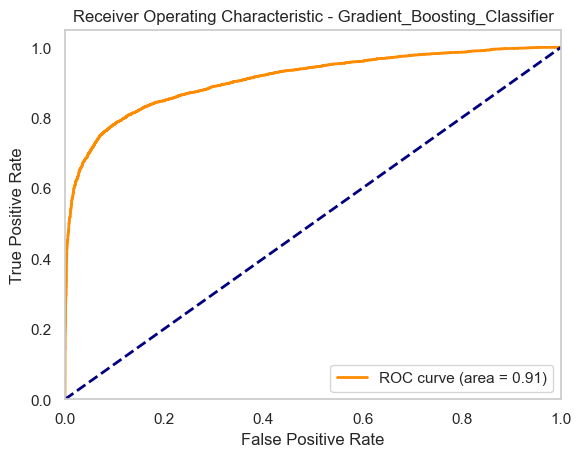



Accuracy: 0.83825






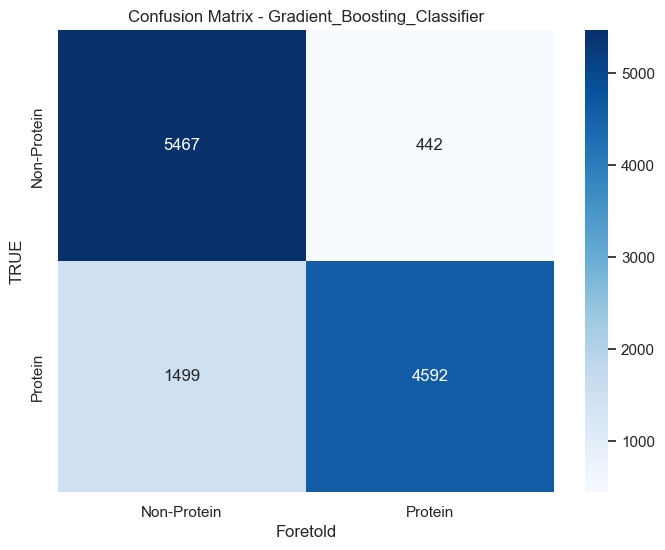



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      5909
           1       0.91      0.75      0.83      6091

    accuracy                           0.84     12000
   macro avg       0.85      0.84      0.84     12000
weighted avg       0.85      0.84      0.84     12000


Machine Learning Model: Decision_Tree_Classifier





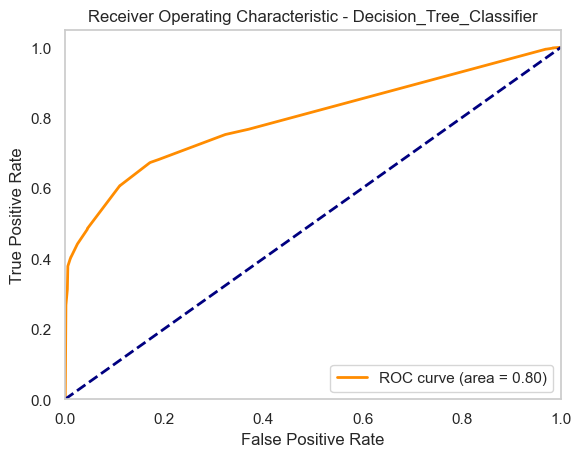



Accuracy: 0.74925






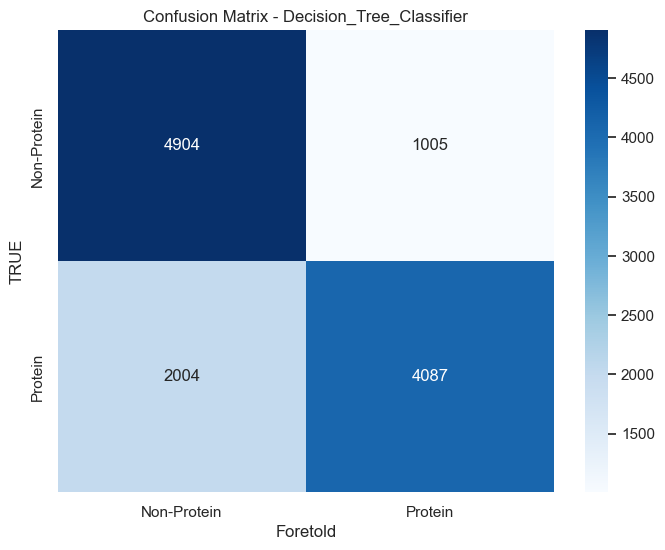



Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      5909
           1       0.80      0.67      0.73      6091

    accuracy                           0.75     12000
   macro avg       0.76      0.75      0.75     12000
weighted avg       0.76      0.75      0.75     12000


Machine Learning Model: Random_Forest





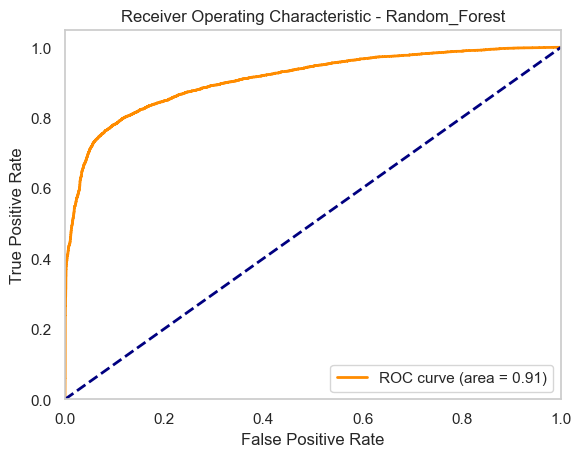



Accuracy: 0.8015






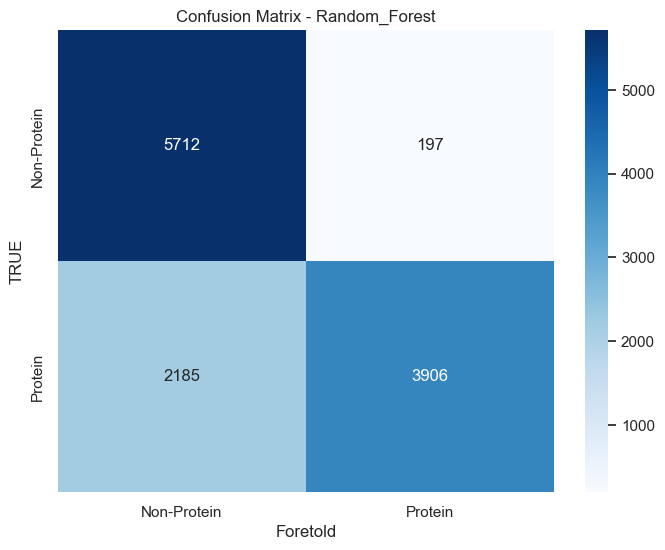



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      5909
           1       0.95      0.64      0.77      6091

    accuracy                           0.80     12000
   macro avg       0.84      0.80      0.80     12000
weighted avg       0.84      0.80      0.80     12000


Machine Learning Model: XGBoost





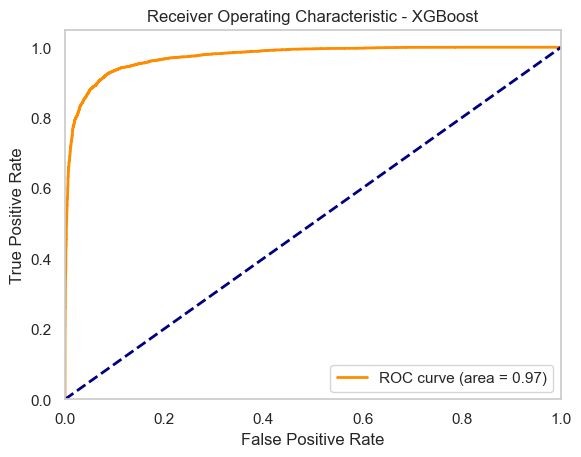



Accuracy: 0.9149166666666667






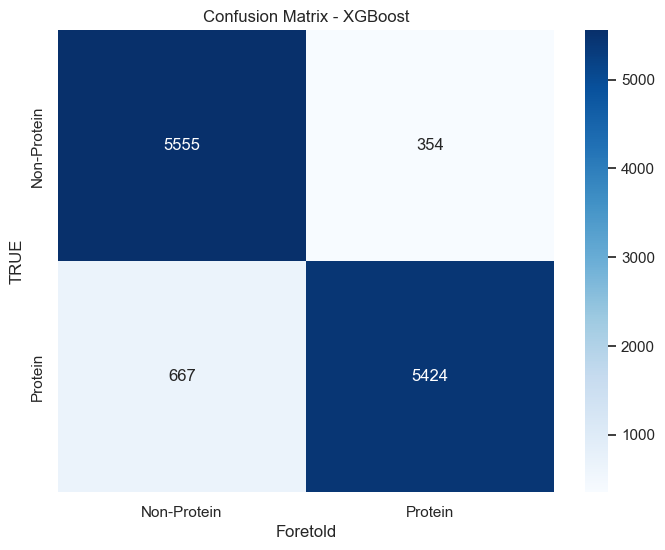



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5909
           1       0.94      0.89      0.91      6091

    accuracy                           0.91     12000
   macro avg       0.92      0.92      0.91     12000
weighted avg       0.92      0.91      0.91     12000

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Machine Learning Model: LGBM
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5





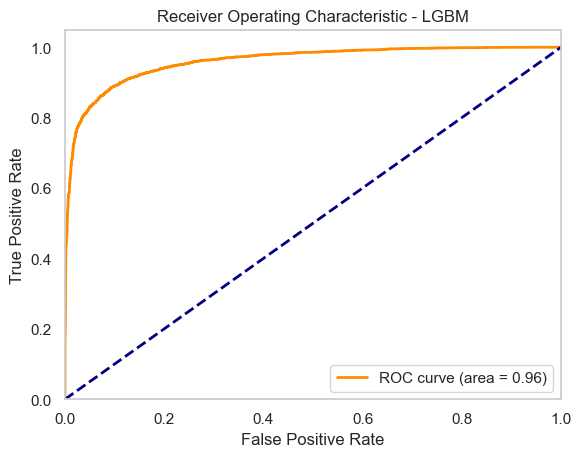



Accuracy: 0.8940833333333333






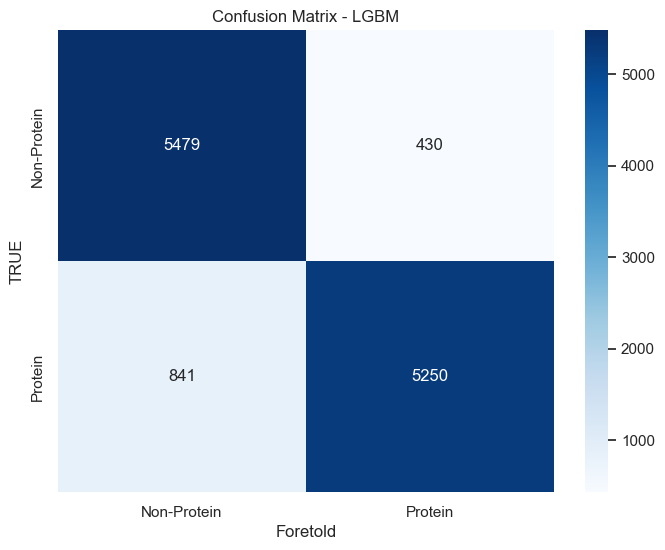



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5909
           1       0.92      0.86      0.89      6091

    accuracy                           0.89     12000
   macro avg       0.90      0.89      0.89     12000
weighted avg       0.90      0.89      0.89     12000


Machine Learning Model: CatBoost





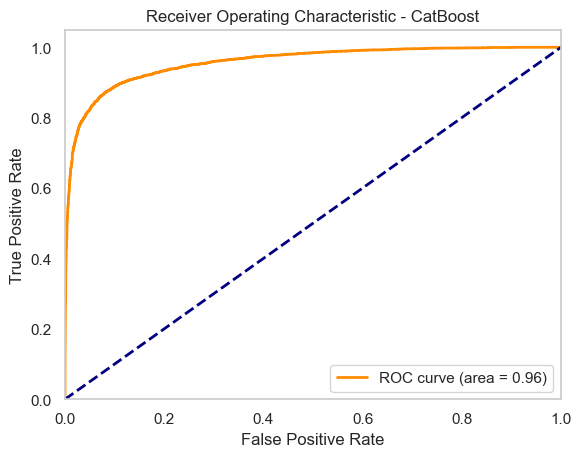



Accuracy: 0.8914166666666666






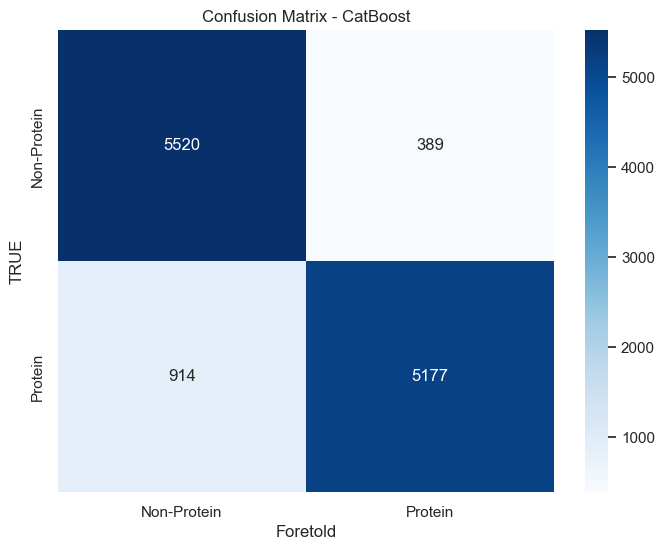



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5909
           1       0.93      0.85      0.89      6091

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000


Machine Learning Model: MLP





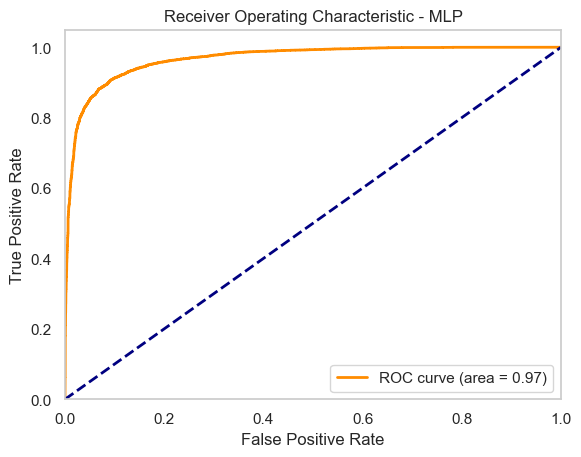



Accuracy: 0.9069166666666667






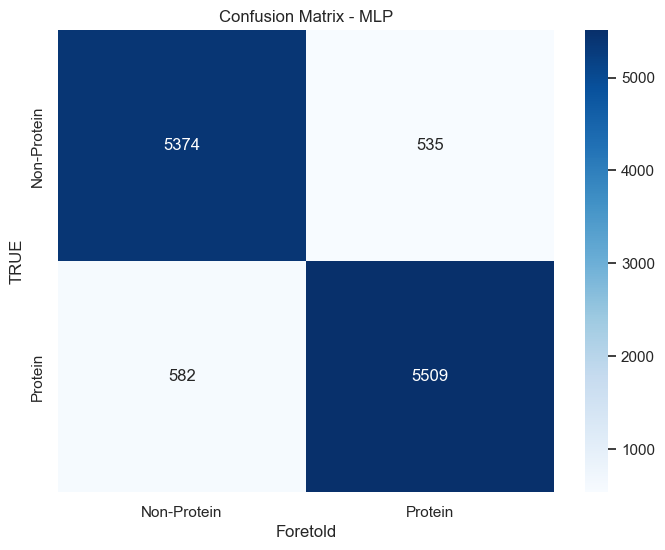



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5909
           1       0.91      0.90      0.91      6091

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [166]:
def plot():
    # Iterating over each model
    for nome, modelo in models.items():

        # Model training
        modelo.fit(X_train, y_train)

        # Prediction on test set
        y_pred = modelo.predict(X_test)

        print()
        print("Machine Learning Model:", nome)

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
        roc_auc = auc(fpr, tpr)
        print()
        print()

        # Plotting the ROC curve
        print()
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic - {}'.format(nome))
        plt.legend(loc="lower right")
        plt.grid(False)
        plt.show()
        print()
        print()
        
        # Accuracy
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy:", acc)
        print()
        print()

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        print()
        print()
        
        # Plotting the confusion matrix with Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix - {}'.format(nome))
        plt.xlabel('Foretold')
        plt.ylabel('TRUE') 
        plt.xticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
        plt.yticks(ticks=[0.5, 1.5], labels=['Non-Protein', 'Protein'])
        plt.show()
        print()
        print()

        # Classification Report
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

plot()

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
                           Model  Accuracy  Average Precision      RMSE
7                        XGBoost  0.917667           0.894361  0.250610
10                           MLP  0.907083           0.874251  0.282379
9                       CatBoost  0.897667           0.874092  0.287466
8                           LGBM  0.894500           0.868191  0.283769
0            Logistic_Regression  0.869083           0.828398  0.308803
4   Gradient_Boosting_Classifier  0.839083           0.814858  0.360203
2                            KNN  0.811417           0.740642  0.369982
6                  Random_Forest  0.806417           0.796227  0.384455
3                      Ada_Boost  0.784167           0.736476  0.494617
5       Decision_Tree_Classifier  0.743083           0.695202  0

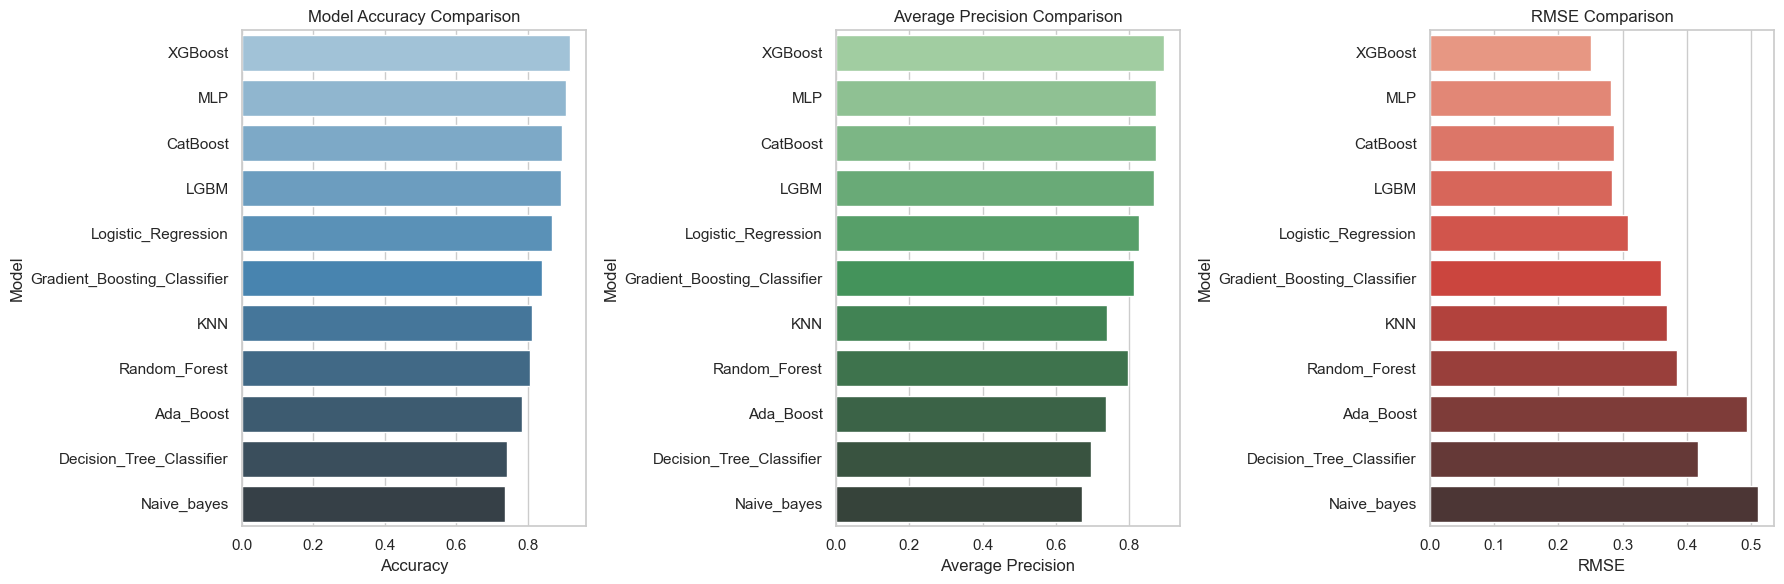

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score, accuracy_score, mean_squared_error
import pandas as pd

def show_all():
    # Dictionary to store accuracy, average precision, and RMSE metrics
    resultados_metricas = {'Model': [], 
                           'Accuracy': [],
                           'Average Precision': [],
                           'RMSE': []  # Add RMSE to the dictionary
                          }

    # Iterating over each model
    for nome, modelo in models.items():
        
        # Model training
        # modelo.fit(X_train, y_train)

        modelo = joblib.load(f"ckpoint/morgan/{nome}_model.pkl")
        # Prediction on test set
        y_pred = modelo.predict(X_test)
        y_pred_prob = modelo.predict_proba(X_test)
        y_pred_prob = y_pred_prob[:, 1]

        # Calculating accuracy
        acc = accuracy_score(y_test, y_pred)
        
        # Calculating average precision
        avg_precision = average_precision_score(y_test, y_pred)

        # Calculating RMSE (Root Mean Squared Error)
        rmse = mean_squared_error(y_test, y_pred_prob, squared=False)  # squared=False gives RMSE

        # Storing accuracy, average precision, and RMSE results in the dictionary
        resultados_metricas['Model'].append(nome)
        resultados_metricas['Accuracy'].append(acc)
        resultados_metricas['Average Precision'].append(avg_precision)
        resultados_metricas['RMSE'].append(rmse)

    # Creating DataFrame with the results
    df_metricas = pd.DataFrame(resultados_metricas)

    # Displaying the DataFrame sorted by accuracy column in descending order
    df_metricas_sorted = df_metricas.sort_values(by='Accuracy', ascending=False)
    print(df_metricas_sorted)
    
    # Plotting the comparison for Accuracy, Average Precision, and RMSE
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    
    # Accuracy plot
    sns.barplot(x='Accuracy', y='Model', data=df_metricas_sorted, ax=axes[0], palette='Blues_d')
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].set_xlabel('Accuracy')
    
    # Average Precision plot
    sns.barplot(x='Average Precision', y='Model', data=df_metricas_sorted, ax=axes[1], palette='Greens_d')
    axes[1].set_title('Average Precision Comparison')
    axes[1].set_xlabel('Average Precision')
    
    # RMSE plot
    sns.barplot(x='RMSE', y='Model', data=df_metricas_sorted, ax=axes[2], palette='Reds_d')
    axes[2].set_title('RMSE Comparison')
    axes[2].set_xlabel('RMSE')

    # Display the plots
    plt.tight_layout()
    plt.show()

show_all()


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


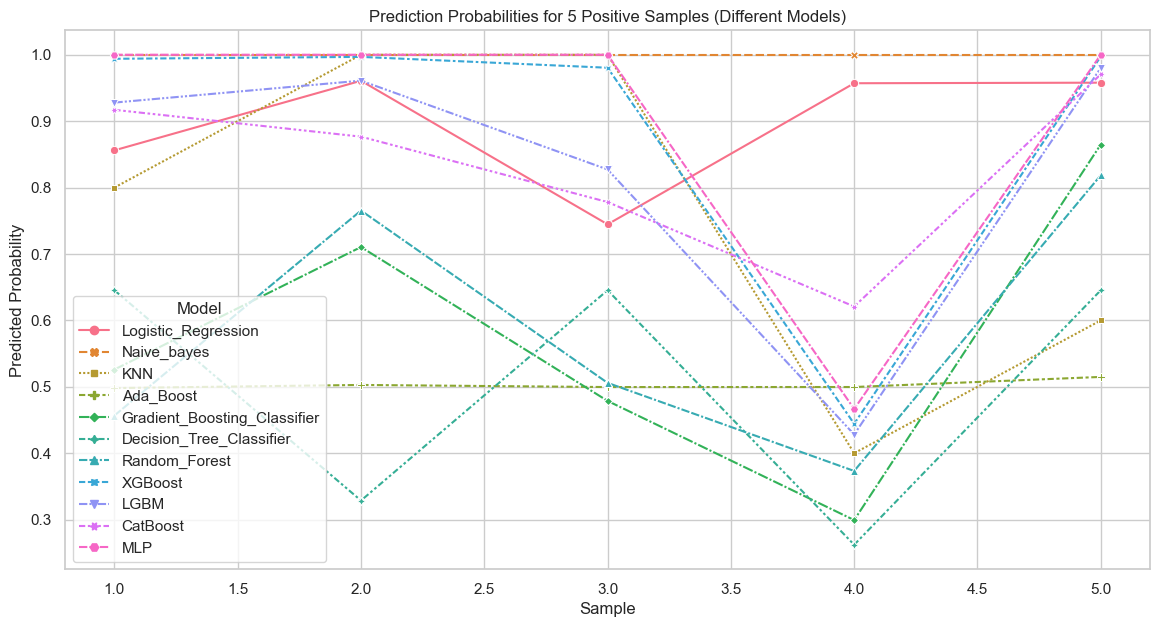

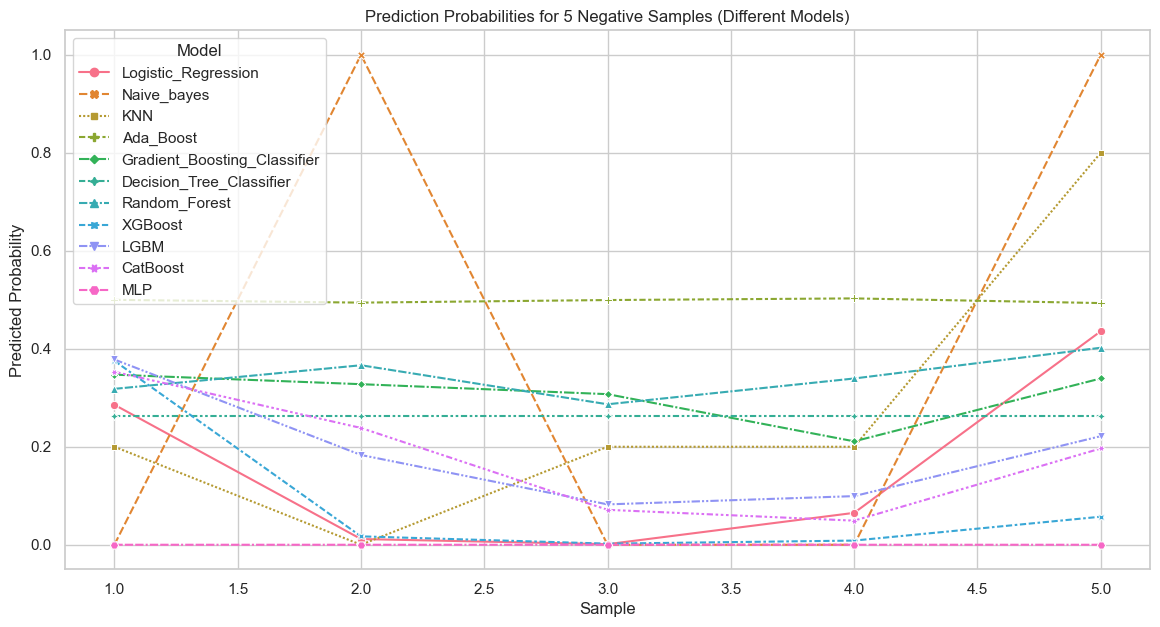

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib


# Machine learning model
models_selected = { 
    
    # model Logistic Regression
    "Logistic_Regression": LogisticRegression(),
    
    # model Naive bayes
    "Naive_bayes": GaussianNB(),
    
    # model KNN
    "KNN": KNeighborsClassifier(),
    
    # model AdaBoost
    "Ada_Boost": AdaBoostClassifier(),
    
    # model Gradient Boosting
    "Gradient_Boosting_Classifier": GradientBoostingClassifier(),
    
    # model Decision Tree Classifier - With adjusted internal parameters
    "Decision_Tree_Classifier": DecisionTreeClassifier(max_depth=5, 
                                                       min_samples_split=2, 
                                                       random_state=105),

    # Random Forest Classifier
    "Random_Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
    
    # model XGBoost - With adjusted internal parameters
    "XGBoost": XGBClassifier(n_estimators=100,
                             max_depth=250,
                             learning_rate=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='multi:softmax',
                             num_class=3,
                             random_state=42,
                             tree_method='gpu_hist'),
    
    # model LGBM - with adjusted internal parameters
    "LGBM": LGBMClassifier(boosting_type='gbdt',
                           bagging_freq=5,
                           verbose=0,
                           device='gpu',
                           num_leaves=31,
                           max_depth=250,
                           learning_rate=0.1,
                           n_estimators=100),

    
    # CatBoost
    "CatBoost": CatBoostClassifier(iterations=100,
                                   learning_rate=0.1,
                                   depth=10,
                                   cat_features=None,  # Specify the categorical feature indices if available
                                   task_type='GPU',
                                   devices='0',  # Set to '0' for the first GPU, adjust if needed
                                   early_stopping_rounds=10,
                                   verbose=0),
    
    # Multi-layer Perception classifier
     "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)

}

def plot_model_probabilities(num_select):
    # Set the random seed for reproducibility
    np.random.seed(64)
    
    # Convert y_test to numpy array for easier indexing
    y_test_arr = np.array(y_test)

    # Get the indices of positive and negative samples
    pos_indices = np.where(y_test_arr == 1)[0]  # Indices of positive samples
    neg_indices = np.where(y_test_arr == 0)[0]  # Indices of negative samples

    # Randomly select num_select positive and num_select negative samples
    pos_samples = [X_test[i] for i in np.random.choice(pos_indices, num_select)]  # num_select random positive samples
    neg_samples = [X_test[i] for i in np.random.choice(neg_indices, num_select)]  # num_select random negative samples

    # Combine positive and negative samples
    selected_pos_samples = pos_samples
    selected_neg_samples = neg_samples
    selected_pos_labels = [1] * num_select  # Labels for positive samples
    selected_neg_labels = [0] * num_select  # Labels for negative samples

    # Initialize empty DataFrame to store prediction results
    prob_results_pos = pd.DataFrame()
    prob_results_neg = pd.DataFrame()

    # Iterate over each model to get the predicted probabilities for the selected positive samples
    for nome, modelo in models_selected.items():
        # Load the model
        modelo = joblib.load(f"ckpoint/morgan/{nome}_model.pkl")
        
        # Predict probabilities for the positive samples
        y_pred_prob_pos = modelo.predict_proba(selected_pos_samples)[:, 1]  # Probabilities for class 1 (positive samples)

        # Store probabilities and corresponding labels in the DataFrame for positive samples
        temp_df_pos = pd.DataFrame({
            'Sample': list(range(1, num_select+1)),  # Sample indices for positive samples (1 to num_select)
            'Model': [nome] * num_select,
            'Probability': y_pred_prob_pos,
            'Label': selected_pos_labels
        })
        prob_results_pos = pd.concat([prob_results_pos, temp_df_pos])

        # Predict probabilities for the negative samples
        y_pred_prob_neg = modelo.predict_proba(selected_neg_samples)[:, 1]  # Probabilities for class 1 (negative samples)

        # Store probabilities and corresponding labels in the DataFrame for negative samples
        temp_df_neg = pd.DataFrame({
            'Sample': list(range(1, num_select+1)),  # Sample indices for negative samples (1 to 10)
            'Model': [nome] * num_select,
            'Probability': y_pred_prob_neg,
            'Label': selected_neg_labels
        })
        prob_results_neg = pd.concat([prob_results_neg, temp_df_neg])

    # Plotting the prediction probabilities for the positive samples
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=prob_results_pos, x='Sample', y='Probability', hue='Model', style='Model', markers=True)
    plt.title(f'Prediction Probabilities for {num_select} Positive Samples (Different Models)')
    plt.xlabel('Sample')
    plt.ylabel('Predicted Probability')
    plt.legend(title='Model')
    plt.show()

    # Plotting the prediction probabilities for the negative samples
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=prob_results_neg, x='Sample', y='Probability', hue='Model', style='Model', markers=True)
    plt.title(f'Prediction Probabilities for {num_select} Negative Samples (Different Models)')
    plt.xlabel('Sample')
    plt.ylabel('Predicted Probability')
    plt.legend(title='Model')
    plt.show()

plot_model_probabilities(5)


In [169]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem

# Function to calculate fingerprints and save in chunks
def modl(molecule_data, radius=2, bits=1024):
    if molecule_data is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule_data, radius, nBits=bits))

def process_in_batches(test_path, batch_size=1000, output_path="output/test_morgan.parquet"):
    # Read the Parquet file using pyarrow
    parquet_file = pq.ParquetFile(test_path)
    
    # Initialize an empty list to store processed chunks
    processed_chunks = []
    
    # Calculate the total number of row groups
    total_row_groups = parquet_file.num_row_groups
    
    # Process each row group in batches
    for i in tqdm(range(total_row_groups), desc="Processing batches"):
        # Read the row group into a DataFrame
        data_batch = parquet_file.read_row_group(i).to_pandas()
        
        # Convert SMILES to molecules
        data_batch['molecule'] = data_batch['molecule_smiles'].apply(Chem.MolFromSmiles)
        
        # Create the fingerprint column in chunks
        data_batch['H1_ecfp'] = data_batch['molecule'].apply(modl)
        
        # Drop the 'molecule' column to save memory and avoid saving it
        data_batch = data_batch.drop(columns=['molecule'])
        
        # Append processed batch to the list
        processed_chunks.append(data_batch)
    
    # Concatenate all processed chunks and save to disk
    final_data = pd.concat(processed_chunks, axis=0)
    final_data.to_parquet(output_path)

# Call the function to process and store the result
# process_in_batches(test_path)


In [170]:
# Load the processed Parquet file into a DataFrame
data_to_predict = pd.read_parquet("output/test_morgan.parquet")
print(type(data_to_predict)) 
# Display the first few rows to check the loaded data
print(data_to_predict.head())

<class 'pandas.core.frame.DataFrame'>
          id                            buildingblock1_smiles  \
0  295246830  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
1  295246831  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
2  295246832  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
3  295246833  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   
4  295246834  C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O   

  buildingblock2_smiles   buildingblock3_smiles  \
0        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
1        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
2        C=Cc1ccc(N)cc1          C=Cc1ccc(N)cc1   
3        C=Cc1ccc(N)cc1  CC(O)Cn1cnc2c(N)ncnc21   
4        C=Cc1ccc(N)cc1  CC(O)Cn1cnc2c(N)ncnc21   

                                     molecule_smiles protein_name  \
0  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...         BRD4   
1  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...          HSA   
2  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...     

In [171]:
# Creating an instance
encoder_onehot = OneHotEncoder(sparse_output=False)
# Training
encoder_onehot_fit_pre = encoder_onehot.fit_transform(data_to_predict['protein_name'].values.reshape(-1, 1))
print(encoder_onehot_fit_pre.shape)
print(data_to_predict['H1_ecfp'].shape)

# 确保 'H1_ecfp' 是一个长度为 1024 的数组
ecfp_array = np.array(data_to_predict['H1_ecfp'].tolist())  # 转换为二维数组，形状是 (1674896, 1024)
print(ecfp_array.shape)
# # Combine ECFPs and one-hot encoded protein_name
# 合并两个特征矩阵：ECFP + one-hot 编码的 protein_name
X_to_predict = np.concatenate([ecfp_array, encoder_onehot_fit_pre], axis=1)
# X_to_predict = [ecfp + protein for ecfp, protein in zip(data_to_predict['H1_ecfp'].tolist(), encoder_onehot_fit_pre.tolist())]

(1674896, 3)
(1674896,)
(1674896, 1024)


In [172]:
print(X_to_predict.shape)

(1674896, 1027)


In [173]:
data_to_predict['id'][:]

0         295246830
1         295246831
2         295246832
3         295246833
4         295246834
            ...    
626315    296921721
626316    296921722
626317    296921723
626318    296921724
626319    296921725
Name: id, Length: 1674896, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib

# 假设 models 已经加载并包含所有训练好的模型
models = {
    "Logistic_Regression": joblib.load("ckpoint/morgan/Logistic_Regression_model.pkl"),
    "Naive_bayes": joblib.load("ckpoint/morgan/Naive_bayes_model.pkl"),
    "KNN": joblib.load("ckpoint/morgan/KNN_model.pkl"),
    "Ada_Boost": joblib.load("ckpoint/morgan/Ada_Boost_model.pkl"),
    "Gradient_Boosting_Classifier": joblib.load("ckpoint/morgan/Gradient_Boosting_Classifier_model.pkl"),
    "Decision_Tree_Classifier": joblib.load("ckpoint/morgan/Decision_Tree_Classifier_model.pkl"),
    "Random_Forest": joblib.load("ckpoint/morgan/Random_Forest_model.pkl"),
    "XGBoost": joblib.load("ckpoint/morgan/XGBoost_model.pkl"),
    "LGBM": joblib.load("ckpoint/morgan/LGBM_model.pkl"),
    "CatBoost": joblib.load("ckpoint/morgan/CatBoost_model.pkl"),
    "MLP": joblib.load("ckpoint/morgan/MLP_model.pkl")
}


# 分批推理处理
def batch_predict(X_to_predict, batch_size=1000):
    data_iterator = np.array_split(X_to_predict, len(X_to_predict) // batch_size)  # 将数据拆分为批次
    for model_name in models.keys():
        all_predictions = []
        for batch in tqdm(data_iterator, desc=f"Processing {model_name} in batches"):
            prob_predictions = models[model_name].predict_proba(batch)
            positive_probabilities = prob_predictions[:, 1]
            all_predictions.extend(positive_probabilities)  # 追加每个批次的预测结果

        # 保存最终结果到CSV文件
        output_path = f"ckpoint/morgan/{model_name}_submission.csv"
        df = pd.DataFrame({
            'id': data_to_predict['id'],
            'binds': all_predictions
        })
        df.to_csv(output_path, index=False)
        print(f"Results for {model_name} saved to {output_path}")

# 调用函数进行批次预测和保存
# batch_predict(X_to_predict)


: 